### Loading Packages

In [1]:
import os
import sys
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import string
import operator

import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics.pairwise import cosine_similarity
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc

import pygraphviz 
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

import gensim
from gensim import corpora
from gensim import models
from gensim import similarities
from gensim.models import Word2Vec

### Importing the saved dataframe

In [2]:
df_recipes = pd.read_pickle('./basic_features.pkl.bz2')
df_recipes.head()

,old_id,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
id,,,,,,,,,,,,,,,,,,
424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]",aromatic basmati rice rice cooker,61,496803,2010-05-10,"[weeknight, time-to-make, course, main-ingredi...","[228.2, 2.0, 2.0, 8.0, 9.0, 1.0, 15.0]",6,"[rinse the rice in a fine strainer , then drai...",from the ultimate rice cooker cookbook. the a...,"[basmati rice, water, salt, cinnamon stick, gr...",5
146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,...",pumpkin pie a la easy,55,229619,2005-11-25,"[60-minutes-or-less, time-to-make, course, pre...","[249.4, 16.0, 92.0, 8.0, 11.0, 27.0, 11.0]",10,"[preheat oven to 350, combine flour , oats , b...",this is a pampered chef recipe for their stone...,"[flour, oats, brown sugar, pecans, butter, egg...",12
312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696...",cheesy tomato soup with potatoes,25,621626,2008-07-07,"[30-minutes-or-less, time-to-make, course, mai...","[351.3, 34.0, 15.0, 50.0, 25.0, 70.0, 8.0]",6,"[pour the broth & water into a large pot, add ...",after modifying another recipe i came up with ...,"[chicken broth, water, salt, black pepper, oni...",15
74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]",mini tacos,15,60989,2003-10-29,"[15-minutes-or-less, time-to-make, course, mai...","[79.7, 5.0, 2.0, 11.0, 11.0, 7.0, 2.0]",8,"[cook hamburger until browned, drain the fat a...",these can be a easy appetizer or a light dinne...,"[wonton wrappers, hamburger, taco seasoning, s...",8
76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]",rosemary s hanky panky s,20,93444,2003-11-12,"[30-minutes-or-less, time-to-make, course, pre...","[240.7, 29.0, 9.0, 28.0, 27.0, 42.0, 0.0]",5,"[fry ground beef and sausage until browned, dr...",my girlfriend rosemary gave me this wonderfull...,"[ground beef, ground sausage, velveeta cheese,...",4


In [3]:
df_recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178265 entries, 424415 to 263840
Data columns (total 18 columns):
old_id               178265 non-null int64
name_tokens          178265 non-null object
ingredient_tokens    178265 non-null object
steps_tokens         178265 non-null object
techniques           178265 non-null object
calorie_level        178265 non-null int64
ingredient_ids       178265 non-null object
name                 178265 non-null object
minutes              178265 non-null int64
contributor_id       178265 non-null int64
submitted            178265 non-null object
tags                 178265 non-null object
nutrition            178265 non-null object
n_steps              178265 non-null int64
steps                178265 non-null object
description          174311 non-null object
ingredients          178265 non-null object
n_ingredients        178265 non-null int64
dtypes: int64(6), object(12)
memory usage: 25.8+ MB


In [4]:
print(df_recipes['ingredients'].iloc[0])
print(df_recipes['ingredient_ids'].iloc[0])

['basmati rice', 'water', 'salt', 'cinnamon stick', 'green cardamom pods']
[389, 7655, 6270, 1527, 3406]


In [5]:
selected = pd.read_csv("./selected_recipes.csv")
selected.set_index(["id_recipe"], drop=True, inplace=True)
selected.drop(['Unnamed: 0', 'minutes', 'ingredients'], axis=1, inplace=True)

In [6]:
selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 91809 to 424845
Data columns (total 12 columns):
image            72 non-null object
nationality      72 non-null object
rating           72 non-null float64
calories         72 non-null float64
total fat        72 non-null float64
sugar            72 non-null float64
sodium           72 non-null float64
protein          72 non-null float64
saturated fat    72 non-null float64
carbohydrates    72 non-null float64
original_name    72 non-null object
recipe           72 non-null object
dtypes: float64(8), object(4)
memory usage: 7.3+ KB


In [7]:
selected = selected.merge(df_recipes, left_index=True, right_index=True)

In [8]:
selected.head(2)

,image,nationality,rating,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates,...,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
263437,https://www.196flavors.com/wp-content/uploads/...,Iranian,5.0,352.2,18.0,110.0,20.0,43.0,24.0,14.0,...,90,637268,2007-11-05,"[time-to-make, course, main-ingredient, cuisin...","[352.2, 18.0, 110.0, 20.0, 43.0, 24.0, 14.0]",12,[peel the eggplant and cut it lengthwise in ha...,bademjan means “eggplant” in farsi (otherwise ...,"[eggplant, lamb, tomato paste, lemon, onion, t...",7
425696,http://www.anupskitchen.com/wp-content/uploads...,Iranian,4.0,280.5,12.0,9.0,19.0,64.0,16.0,6.0,...,105,480195,2010-05-16,"[time-to-make, preparation, 4-hours-or-less]","[280.5, 12.0, 9.0, 19.0, 64.0, 16.0, 6.0]",17,"[simmer lamb , whole dried limes , garlic and ...",for zwt 6 - middle east. i got this recipe fro...,"[lean lamb, dried limes, garlic cloves, water,...",13


In [9]:
selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 263437 to 424874
Data columns (total 30 columns):
image                42 non-null object
nationality          42 non-null object
rating               42 non-null float64
calories             42 non-null float64
total fat            42 non-null float64
sugar                42 non-null float64
sodium               42 non-null float64
protein              42 non-null float64
saturated fat        42 non-null float64
carbohydrates        42 non-null float64
original_name        42 non-null object
recipe               42 non-null object
old_id               42 non-null int64
name_tokens          42 non-null object
ingredient_tokens    42 non-null object
steps_tokens         42 non-null object
techniques           42 non-null object
calorie_level        42 non-null int64
ingredient_ids       42 non-null object
name                 42 non-null object
minutes              42 non-null int64
contributor_id       42 non-null int64
subm

### Creating the vectors for calculating similarities

In [10]:
ingredients = {}
for idx in selected.index:
    temp = dict(zip(selected.loc[idx, "ingredient_ids"],selected.loc[idx, "ingredients"]))
    ingredients.update(temp)

In [11]:
ingredients_matrix = np.zeros((len(selected),max(ingredients)+1), dtype=np.int8, order='C')

In [12]:
ingredients_matrix.shape

(42, 8022)

In [13]:
for idx, idx2 in enumerate(selected.index):
    for ing in selected.loc[idx2,"ingredient_ids"]:
        ingredients_matrix[idx,ing] = 1

In [14]:
len(ingredients_matrix[ingredients_matrix > 0])

397

#### Creating the dish x ingredient matrix from dictionary

In [15]:
df_ingredients = pd.DataFrame(data=ingredients_matrix,
                              index=selected.index,
                              #columns=ingredients.values()
                              )
#df_ingredients.reset_index(inplace=True)
df_ingredients = df_ingredients.loc[:, (df_ingredients != 0).any(axis=0)]

df_ingredients.head()

,63,81,122,150,221,288,332,335,382,384,...,7821,7853,7887,7946,7956,7962,7979,7987,7998,8021
263437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
425696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
439341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173527,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0


### Testing the similarity function
(with the selected recipes)

In [16]:
selected.original_name

263437                   Bademjan
425696               Gormeh Sabzi
157525              Jeweled Rice 
439341                    Baklava
173527                  Basbousa 
280393                  Fattoush 
173528               Ful Medames 
204332                 Muhammara 
33606                       Pasta
455567                  Doro Wat 
316669                     Coffee
157174                 Rogan Josh
481431                      Lassi
108634           Tandoori Chicken
357820               Palak paneer
499504                       Naan
366562       Chicken Tikka Masala
199655                Chilaquiles
81185                        Mole
72065                     Tamales
405929                     Pozole
99043             Tacos al Pastor
197709             Pan con tomate
190891                    Chorizo
66329              Patatas bravas
254556                  Croquetas
84797                      Fondue
86768                       Rosti
33778              milk chocolate
40601         

In [17]:
%%time
similar = []
id_dish = 204332
for idx in df_ingredients.index:
    similar.append((idx, 
                    cosine_similarity(df_ingredients.loc[id_dish,:].values.reshape(1, -1), 
                                      df_ingredients.loc[idx,:].values.reshape(1, -1))[0][0]))
similar.sort(key=operator.itemgetter(1), reverse=True)
print(f'Dishes similar to: {selected.loc[id_dish, "original_name"]}')
print()
for idx, measure in similar:
    print(selected.loc[idx, "original_name"])

Dishes similar to: Muhammara 

Muhammara 
Coffee
Croquetas
Fattoush 
Patatas bravas
Ratatouille
Chicken Tikka Masala
Ful Medames 
Pan con tomate
Naan
Bademjan
Mole
Chorizo
Pizza Margherita
Saltimbocca alla romana
Chilaquiles
Tartiflette
Lassi
Fondue
Tacos al Pastor
Tafelspitz
Beef bourguignon
Palak paneer
Pasta
Doro Wat 
Gormeh Sabzi
Jeweled Rice 
Baklava
Basbousa 
Rogan Josh
Tandoori Chicken
Tamales
Pozole
Rosti
milk chocolate
Tarte tatin
Pasta Carbonara
Arancini
Lasagne
Parmigiana 
Pasta Amatriciana
Tiramisu
CPU times: user 44.8 ms, sys: 41 µs, total: 44.8 ms
Wall time: 43.8 ms


In [18]:
%%time
msim_ingredients = cosine_similarity(df_ingredients.values, df_ingredients.values)
print(msim_ingredients.shape)

(42, 42)
CPU times: user 17.4 ms, sys: 15.9 ms, total: 33.3 ms
Wall time: 19.1 ms


In [19]:
msim_ingredients.shape

(42, 42)

#### Plotting the similarities Matrix

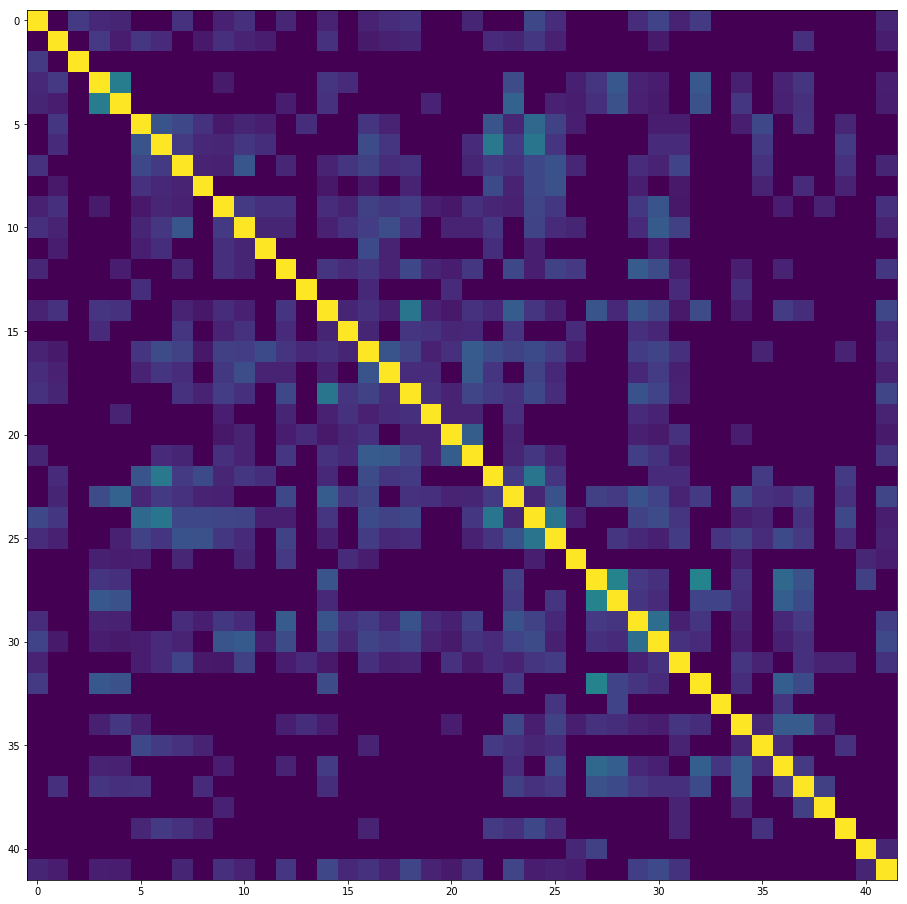

In [20]:
plt.figure(figsize=(16, 16)) 
plt.imshow(msim_ingredients, interpolation='none')
plt.show()

#### Plotting the hierarquical cluster (Dendrogram)

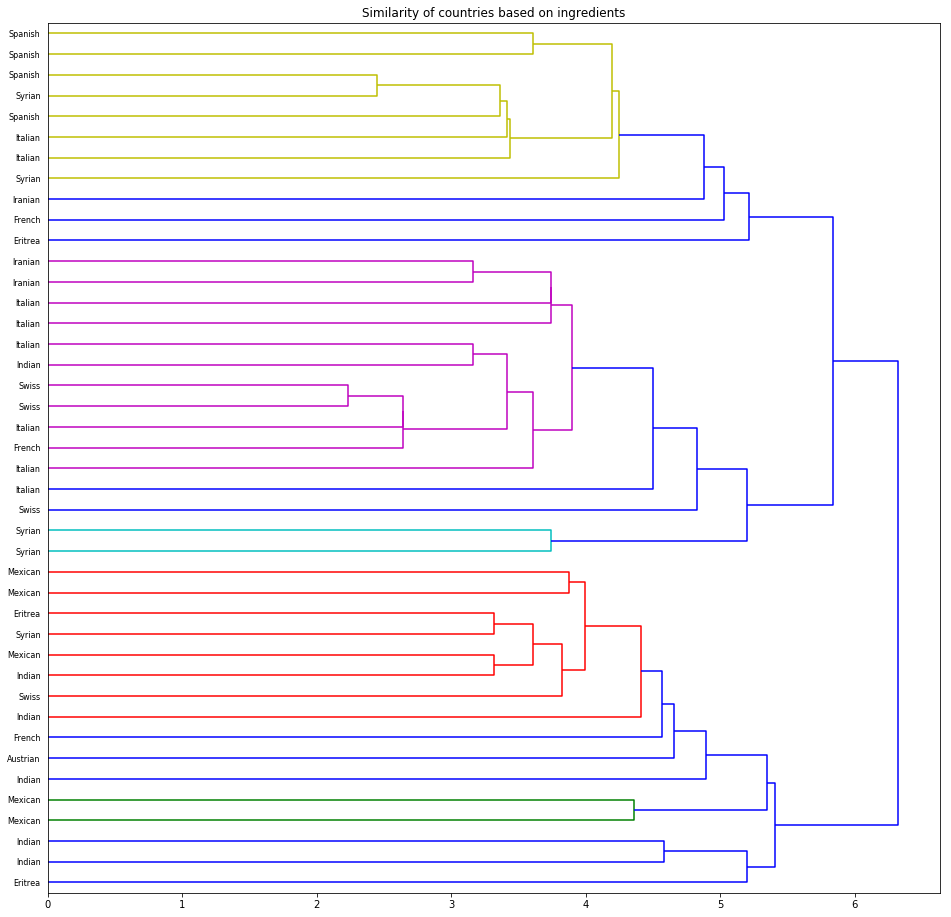

In [21]:
plt.figure(figsize=(16, 16))  
plt.title("Similarity of countries based on ingredients")  
dend = shc.dendrogram(shc.linkage(df_ingredients, method='ward'), 
                      orientation='right', 
                      #labels= selected['original_name'].values)
                      labels= selected['nationality'].values)
plt.savefig("dendogram_country_ingredient.jpg")

In [56]:
G = nx.Graph()
for k,v in ingredients.items():
    G.add_node(v, idx=k, color='cyan')
    
for idx in selected.index:
    G.add_node(selected.loc[idx,'original_name'], idx=idx, color='yellow', country=selected.loc[idx,'nationality'])

for idx in selected.index:
    for column in df_ingredients.columns:
        if df_ingredients.loc[idx, column] == 1:
            G.add_edge(selected.loc[idx,'original_name'], ingredients[column], length = 10)

In [57]:
#nx.get_node_attributes(G,'id')
print(G.node['eggplant'])
print(ingredients[2516])
print(G.node['Tafelspitz'])
print(selected[selected.original_name == 'Tafelspitz'][['original_name','ingredients']])

{'idx': 2516, 'color': 'cyan'}
eggplant
{'idx': 424874, 'color': 'yellow', 'country': 'Austrian'}
       original_name                                        ingredients
424874    Tafelspitz  [beef brisket, water, salt, leeks, onion, carr...


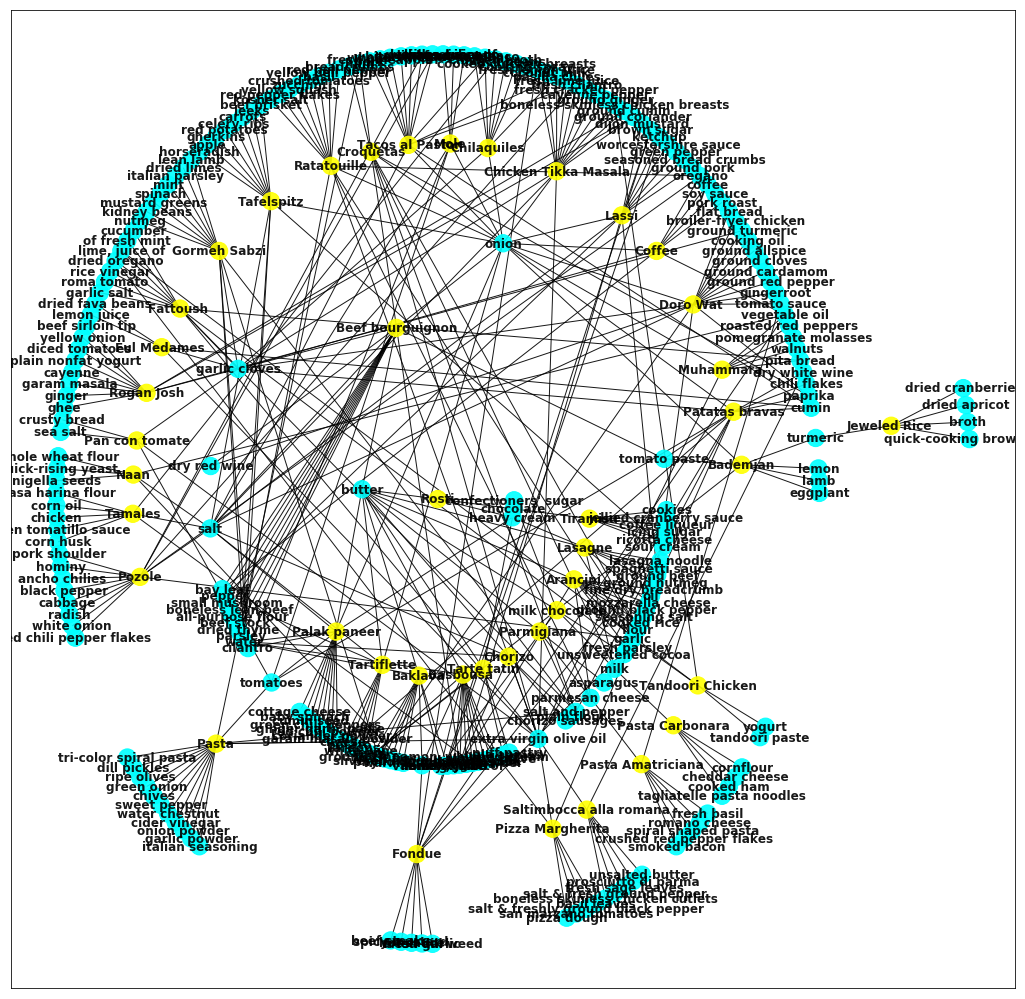

In [58]:
plt.figure(figsize=(18,18))
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 #width=5,
                 alpha=0.9,
                 #cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 font_weight='bold', 
                 #font_color=nx.get_node_attributes(G,'color').values(),
                 )


#plt.show()
plt.savefig('./graph_foods.png', bbox_inches='tight')

In [59]:
G = nx.Graph()
for k,v in ingredients.items():
    G.add_node(v, idx=k, color='cyan')
    
for idx in selected.index:
    G.add_node(selected.loc[idx,'nationality'], idx=idx, color='yellow')

for idx in selected.index:
    for column in df_ingredients.columns:
        if df_ingredients.loc[idx, column] == 1:
            G.add_edge(selected.loc[idx,'nationality'], ingredients[column], length = 10)

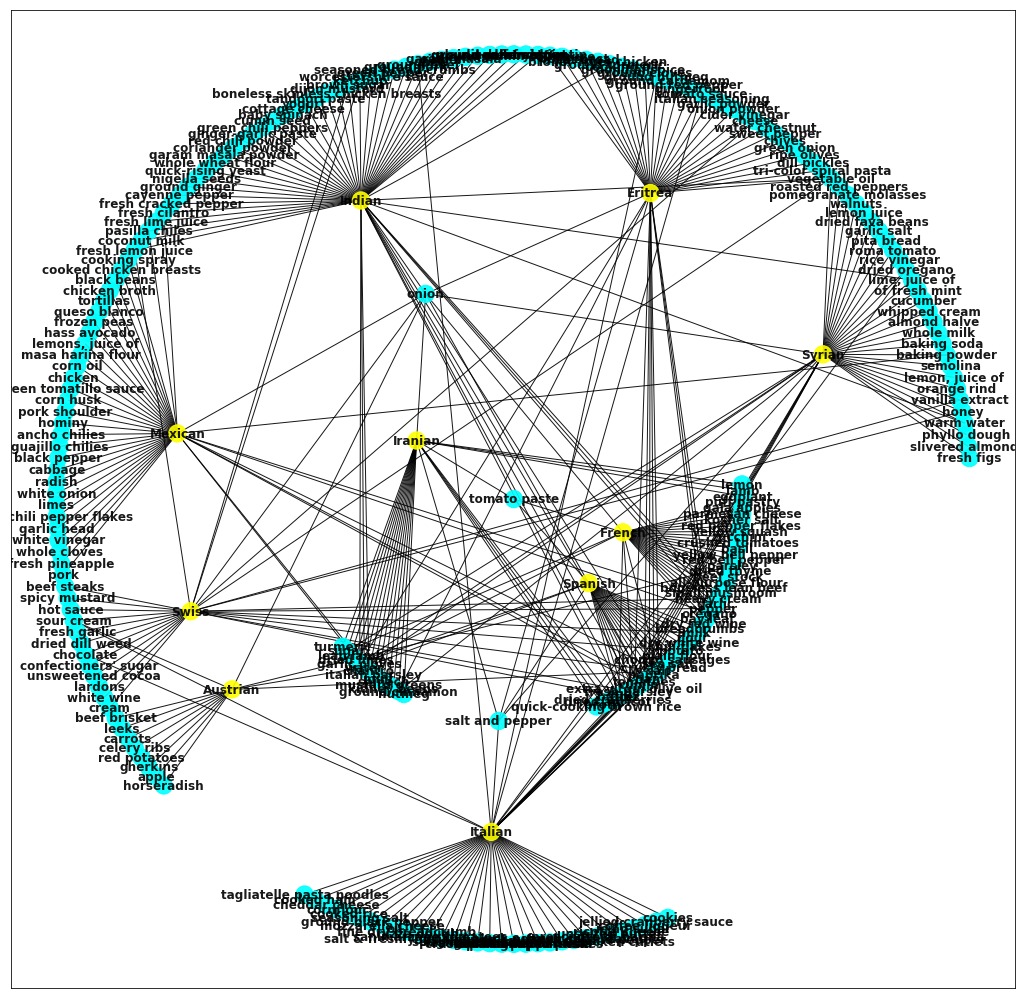

In [60]:
plt.figure(figsize=(18,18))
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 #width=5,
                 alpha=0.9,
                 #cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 font_weight='bold', 
                 #font_color=nx.get_node_attributes(G,'color').values(),
                 )


#plt.show()
plt.savefig('./graph_foods2.png', bbox_inches='tight')

### Finding similar names for recipes
#### (input for the search function)

In [157]:
class Text_Cleaning_Utilities(object):
    """Tools for processing text into segments for further learning"""

    @staticmethod
    def text_to_wordlist(text, 
                         remove_stopwords=False, 
                         remove_non_letters=False, 
                         steeming=False):
        '''Split a text into a list of words'''
        #text = text.replace('-\n','')
        text = text.lower()
        if remove_non_letters:
            text = re.sub("[^-A-Za-z0-9_]", " ", text)
        list_words = word_tokenize(text)
        list_words = [w.strip(string.punctuation) for w in list_words if w not in string.punctuation]
        list_words = [w for w in list_words if len(w) > 1]
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            list_words = [w for w in list_words if w not in stops]
        if steeming:
            stemmer = PorterStemmer()
            list_words = [stemmer.stem(item) for item in list_words]
        return list_words
    
    @staticmethod
    def df_to_list_of_texts(dataframe, column, 
                            remove_stopwords=False, 
                            remove_non_letters=False, 
                            steeming=False):
        clean_texts = []
        for txt_id in range(len(dataframe[column])):
            clean_texts.append(' '.join(Text_Cleaning_Utilities.text_to_wordlist(dataframe[column][txt_id],
                                                                                 remove_stopwords=remove_stopwords,
                                                                                 remove_non_letters=remove_non_letters,
                                                                                 steeming=steeming)))
            
        return clean_texts

    @staticmethod
    def df_to_list_of_tokens(dataframe, column, 
                             remove_stopwords=False, 
                             remove_non_letters=False, 
                             steeming=False):
        clean_texts = []
        for txt_id in range(len(dataframe[column])):
            clean_texts.append(Text_Cleaning_Utilities.text_to_wordlist(dataframe[column][txt_id],
                                                                        remove_stopwords=remove_stopwords,
                                                                        remove_non_letters=remove_non_letters,
                                                                        steeming=steeming))
            
        return clean_texts

In [159]:
recipes = Text_Cleaning_Utilities.df_to_list_of_texts(df_selected,
                                                      'name',
                                                      remove_stopwords=True,)

In [160]:
recipes[0:10]

['arancini italian rice balls',
 'easy fattoush salad',
 'alan tandoori chicken',
 'mexican tacos al pastor',
 'croquetas',
 'best pizza margherita',
 'acadia ratatouille',
 'boneless breast chicken saltimbocca',
 'amanda milk chocolate frosting',
 'ariana pozole']

In [163]:
vectorizer_tf = CountVectorizer(input='content', 
                               encoding='utf-8', 
                               decode_error='strict', 
                               strip_accents=None, 
                               lowercase=True, 
                               preprocessor=None, 
                               tokenizer=None, 
                               stop_words=None, 
                               #token_pattern='(?u)\b\w\w+\b',
                               ngram_range=(1,1),
                               analyzer='word', 
                               max_df=1.0, 
                               min_df=1, 
                               max_features=5000, 
                               vocabulary=None, 
                               binary=False, 
                               dtype=np.int64,
                              )

vectorizer_tfidf = TfidfVectorizer(input='content',
                                  #encoding='utf-8',
                                  decode_error='strict',
                                  strip_accents=None,
                                  lowercase=True,
                                  preprocessor=None,
                                  tokenizer=None,
                                  analyzer='word',
                                  stop_words=None,
                                  #token_pattern='(?u)\b\w\w+\b',
                                  ngram_range=(1, 1),
                                  max_df=1.0,
                                  min_df=1,
                                  max_features=5000,
                                  vocabulary=None, 
                                  binary=False, 
                                  dtype=np.int64,
                                  norm='l2',
                                  use_idf=True,
                                  smooth_idf=True,
                                  sublinear_tf=True)

In [164]:
recipes_vectors = vectorizer_tf.fit_transform(recipes)
recipes_vectors = recipes_vectors.toarray() # Numpy arrays are easy to work with
print(recipes_vectors.shape)

(44, 138)


In [166]:
recipes_vectors[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [167]:
%%time
msim_names = cosine_similarity(recipes_vectors, recipes_vectors)

CPU times: user 1.26 ms, sys: 1.11 ms, total: 2.37 ms
Wall time: 1.39 ms


In [169]:
msim_names.shape

(44, 44)

#### Plotting the similarities Matrix

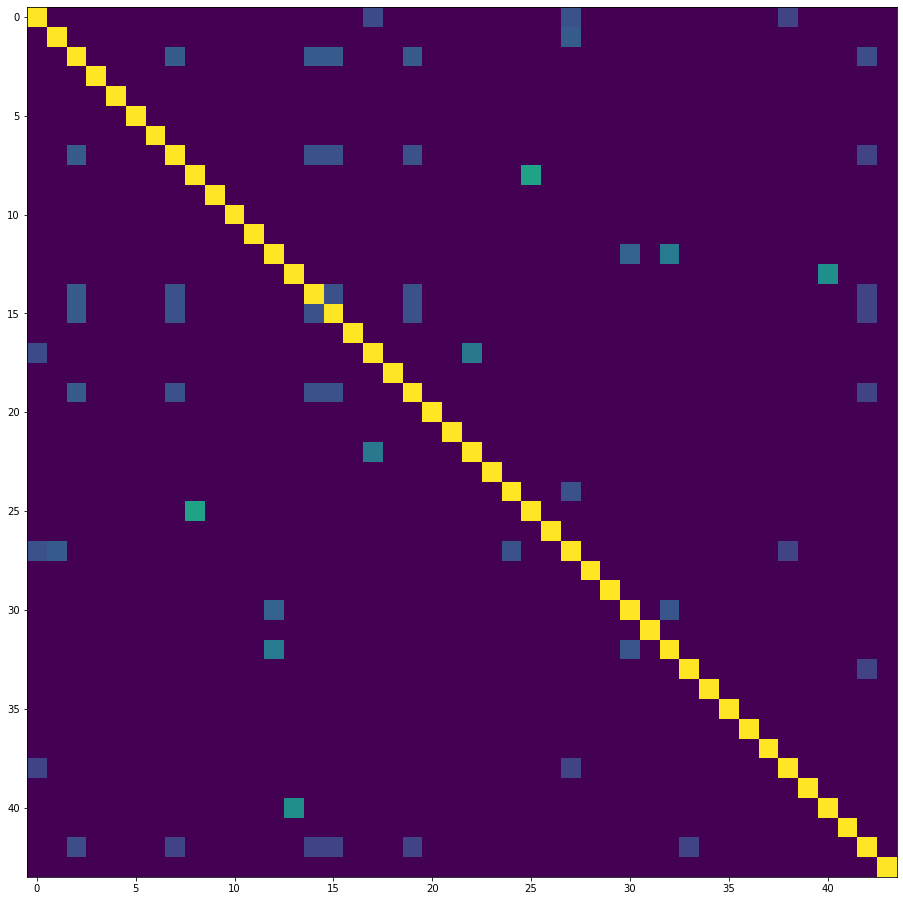

In [170]:
plt.figure(figsize=(16, 16)) 
plt.imshow(msim_names, interpolation='none')
plt.show()

#### Plotting the hierarquical cluster (Dendrogram)

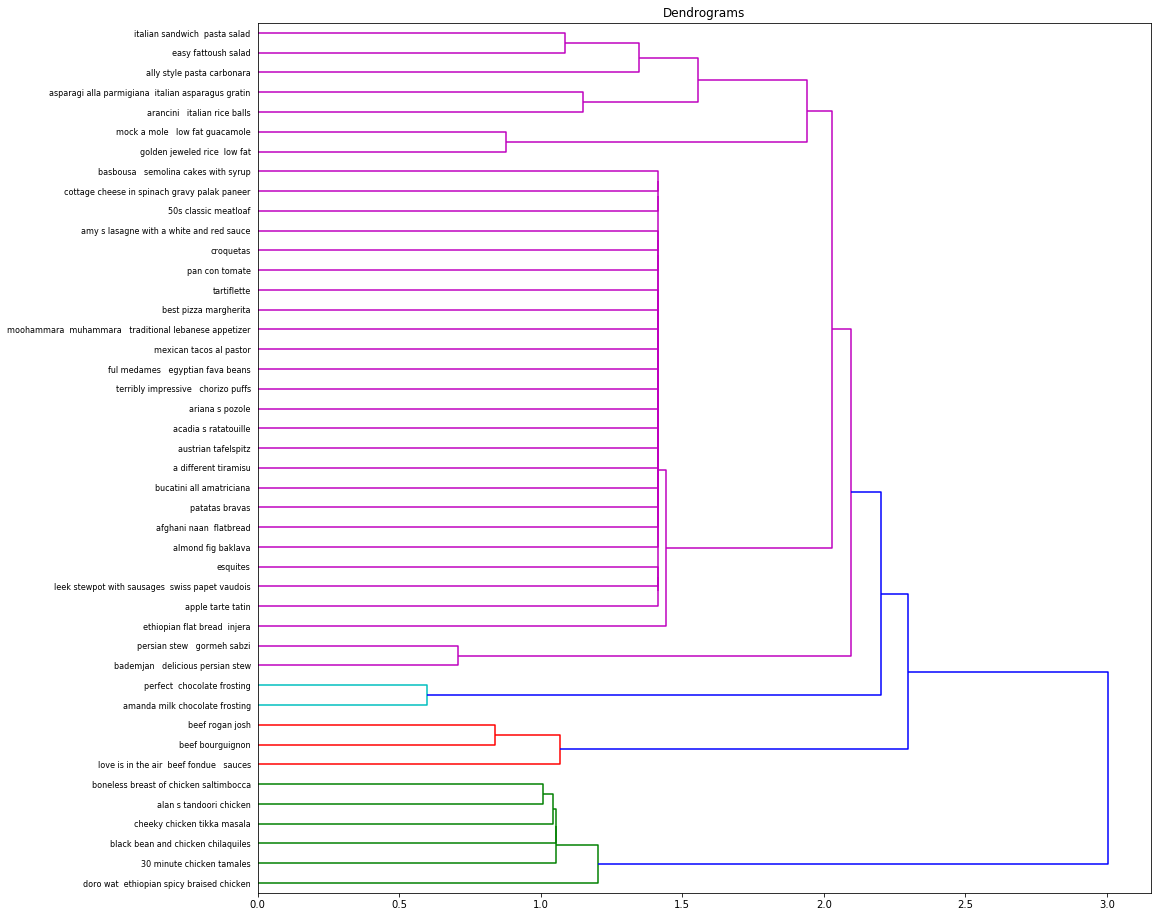

In [171]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(16, 16))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(msim_names, method='ward'), 
                      orientation='right', 
                      labels=df_ingredients.name.values)